In [20]:
# INSTALL REQUIRED PACKAGES
!pip install lime scikit-image -q

# IMPORTS
import os, random, time, json
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from lime import lime_image
from skimage.segmentation import mark_boundaries, quickshift

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# PATHS
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

optimized_model_path = '/kaggle/input/tabu-outputs/tabu_optimized_model (1).keras'
best_params_path = '/kaggle/input/tabu-outputs/tabu_best_parameters.json'

# LOAD MODEL
optimized_model = load_model(optimized_model_path)
print("Optimized model loaded successfully.")

# DATA GENERATOR (for explanations)
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_names = list(test.class_indices.keys())

# SAMPLE IMAGES (
num_eval_images = 10
eval_images, eval_labels = [], []
for _ in range(num_eval_images // test.batch_size + 1):
    batch_images, batch_labels = next(test)
    eval_images.extend(batch_images)
    eval_labels.extend(batch_labels)
eval_images = np.array(eval_images[:num_eval_images])
eval_labels = np.array(eval_labels[:num_eval_images])
print(f"Selected {len(eval_images)} test images for explanations.")

# LIME HELPER FUNCTIONS
def get_lime_explainer():
    return lime_image.LimeImageExplainer()

def custom_segmentation(image, kernel_size, max_dist, ratio):
    return quickshift(image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)

def explain_image(model, image, num_samples, num_features, kernel_size, max_dist, ratio):
    explainer = get_lime_explainer()
    def classifier_fn(images):
        return model.predict(images, verbose=0)
    def segmentation_fn(img):
        return custom_segmentation(img, kernel_size, max_dist, ratio)
    explanation = explainer.explain_instance(
        image, classifier_fn, top_labels=4,
        hide_color=0, num_samples=num_samples,
        segmentation_fn=segmentation_fn
    )
    return explanation

def compute_fidelity(explanation):
    return getattr(explanation, 'score', 0.0)

# TABU SEARCH OPTIMIZER
class TabuSearch_LIME_Optimizer:
    def __init__(self, bounds, max_iter=5, neighborhood_size=3, tabu_tenure=2, aspiration=True):
        self.bounds = bounds
        self.max_iter = max_iter
        self.neighborhood_size = neighborhood_size
        self.tabu_tenure = tabu_tenure
        self.aspiration = aspiration
        self.history = {'iteration': [], 'current_score': [], 'best_score': [], 'parameters': [], 'move_type': [], 'tabu_size': []}
        self.best_params = None
        self.best_score = -np.inf
        self.tabu_list = deque(maxlen=tabu_tenure)

    def _cfg_key(self, solution):
        return tuple(f"{k}:{v:.6f}" if isinstance(v, float) else f"{k}:{v}" for k,v in sorted(solution.items()))

    def generate_initial_solution(self):
        solution = {}
        for param, (low, high, ptype) in self.bounds.items():
            if ptype == 'continuous':
                solution[param] = np.random.uniform(low, high)
            else:
                solution[param] = np.random.randint(low, high+1)
        return solution

    def _random_neighbor(self, current_solution):
        neighbor = current_solution.copy()
        param = random.choice(list(self.bounds.keys()))
        low, high, ptype = self.bounds[param]
        if ptype == 'continuous':
            step = 0.1*(high-low)
            neighbor[param] = np.clip(neighbor[param]+np.random.normal(0, step), low, high)
        else:
            step = 1 if 'features' in param else 100
            neighbor[param] = int(np.clip(neighbor[param]+random.choice([-step, step]), low, high))
        return neighbor, param

    def evaluate_solution(self, solution, model, eval_images, iteration, move_type=""):
    # Correctly map discrete/continuous parameters
        params = {}
        for k, v in solution.items():
            param_type = self.bounds[k][2]
            if param_type == 'discrete':
                params[k] = int(round(v))
            else:
                params[k] = float(v)
    
        fidelities = []
        for img in eval_images:
            exp = explain_image(
                model, img,
                num_samples=params['num_samples'],
                num_features=params['num_features'],
                kernel_size=params['kernel_size'],
                max_dist=params['max_dist'],
                ratio=params['ratio']
            )
            fidelities.append(compute_fidelity(exp))
    
        avg_fid = np.mean(fidelities)
        print(f" Iter {iteration} | Move: {move_type:12s} | Avg Fidelity={avg_fid:.4f}")
        return avg_fid
    def optimize(self, model, eval_images):
        current_solution = self.generate_initial_solution()
        current_score = self.evaluate_solution(current_solution, model, eval_images, 0, "start")
        self.best_params = current_solution.copy()
        self.best_score = current_score
        self.tabu_list.append(self._cfg_key(current_solution))
        self.history['iteration'].append(0)
        self.history['current_score'].append(current_score)
        self.history['best_score'].append(self.best_score)
        self.history['parameters'].append(current_solution.copy())
        self.history['move_type'].append("start")
        self.history['tabu_size'].append(len(self.tabu_list))

        for iteration in range(1, self.max_iter+1):
            candidates = []
            for _ in range(self.neighborhood_size):
                neighbor, move_type = self._random_neighbor(current_solution)
                key = self._cfg_key(neighbor)
                if key in self.tabu_list:
                    continue
                score = self.evaluate_solution(neighbor, model, eval_images, iteration, move_type)
                candidates.append((neighbor, score, move_type, key))
            if not candidates: continue
            neighbor, score, move_type, key = max(candidates, key=lambda x:x[1])
            current_solution, current_score = neighbor, score
            self.tabu_list.append(key)
            if current_score > self.best_score:
                self.best_score = current_score
                self.best_params = current_solution.copy()
            self.history['iteration'].append(iteration)
            self.history['current_score'].append(current_score)
            self.history['best_score'].append(self.best_score)
            self.history['parameters'].append(current_solution.copy())
            self.history['move_type'].append(move_type)
            self.history['tabu_size'].append(len(self.tabu_list))
        return self.best_params, self.best_score

# SEARCH SPACE
lime_bounds = {
    'num_samples': (500, 1500, 'discrete'),
    'num_features': (5, 10, 'discrete'),
    'kernel_size': (2, 6, 'discrete'),
    'max_dist': (5.0, 15.0, 'continuous'),
    'ratio': (0.5, 1.0, 'continuous')
}

# RUN OPTIMIZER
tabu_lime_optimizer = TabuSearch_LIME_Optimizer(
    bounds=lime_bounds,
    max_iter=5,           
    neighborhood_size=3,    
    tabu_tenure=2,
    aspiration=True
)

best_lime_params, best_lime_score = tabu_lime_optimizer.optimize(optimized_model, eval_images)
print("\nBest LIME Parameters:", best_lime_params)
print("Best Average Fidelity:", best_lime_score)

TensorFlow Version: 2.18.0
GPU Available: []
Optimized model loaded successfully.
Found 1311 images belonging to 4 classes.
Selected 10 test images for explanations.


  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

 Iter 0 | Move: start        | Avg Fidelity=0.3099


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 1 | Move: num_samples  | Avg Fidelity=0.3201


  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

 Iter 1 | Move: max_dist     | Avg Fidelity=0.3160


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 2 | Move: ratio        | Avg Fidelity=0.2983


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 2 | Move: ratio        | Avg Fidelity=0.3435


  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

 Iter 3 | Move: num_samples  | Avg Fidelity=0.3449


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 3 | Move: kernel_size  | Avg Fidelity=0.6140


  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

 Iter 4 | Move: num_samples  | Avg Fidelity=0.6016


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 4 | Move: max_dist     | Avg Fidelity=0.6107


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

 Iter 5 | Move: ratio        | Avg Fidelity=0.6081


  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

 Iter 5 | Move: num_samples  | Avg Fidelity=0.6075


  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

 Iter 5 | Move: num_samples  | Avg Fidelity=0.6074

Best LIME Parameters: {'num_samples': 754, 'num_features': 10, 'kernel_size': 6, 'max_dist': 9.089024330428575, 'ratio': 0.6140906121063531}
Best Average Fidelity: 0.6139983408711893



Generating example explanations with optimized LIME parameters...


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

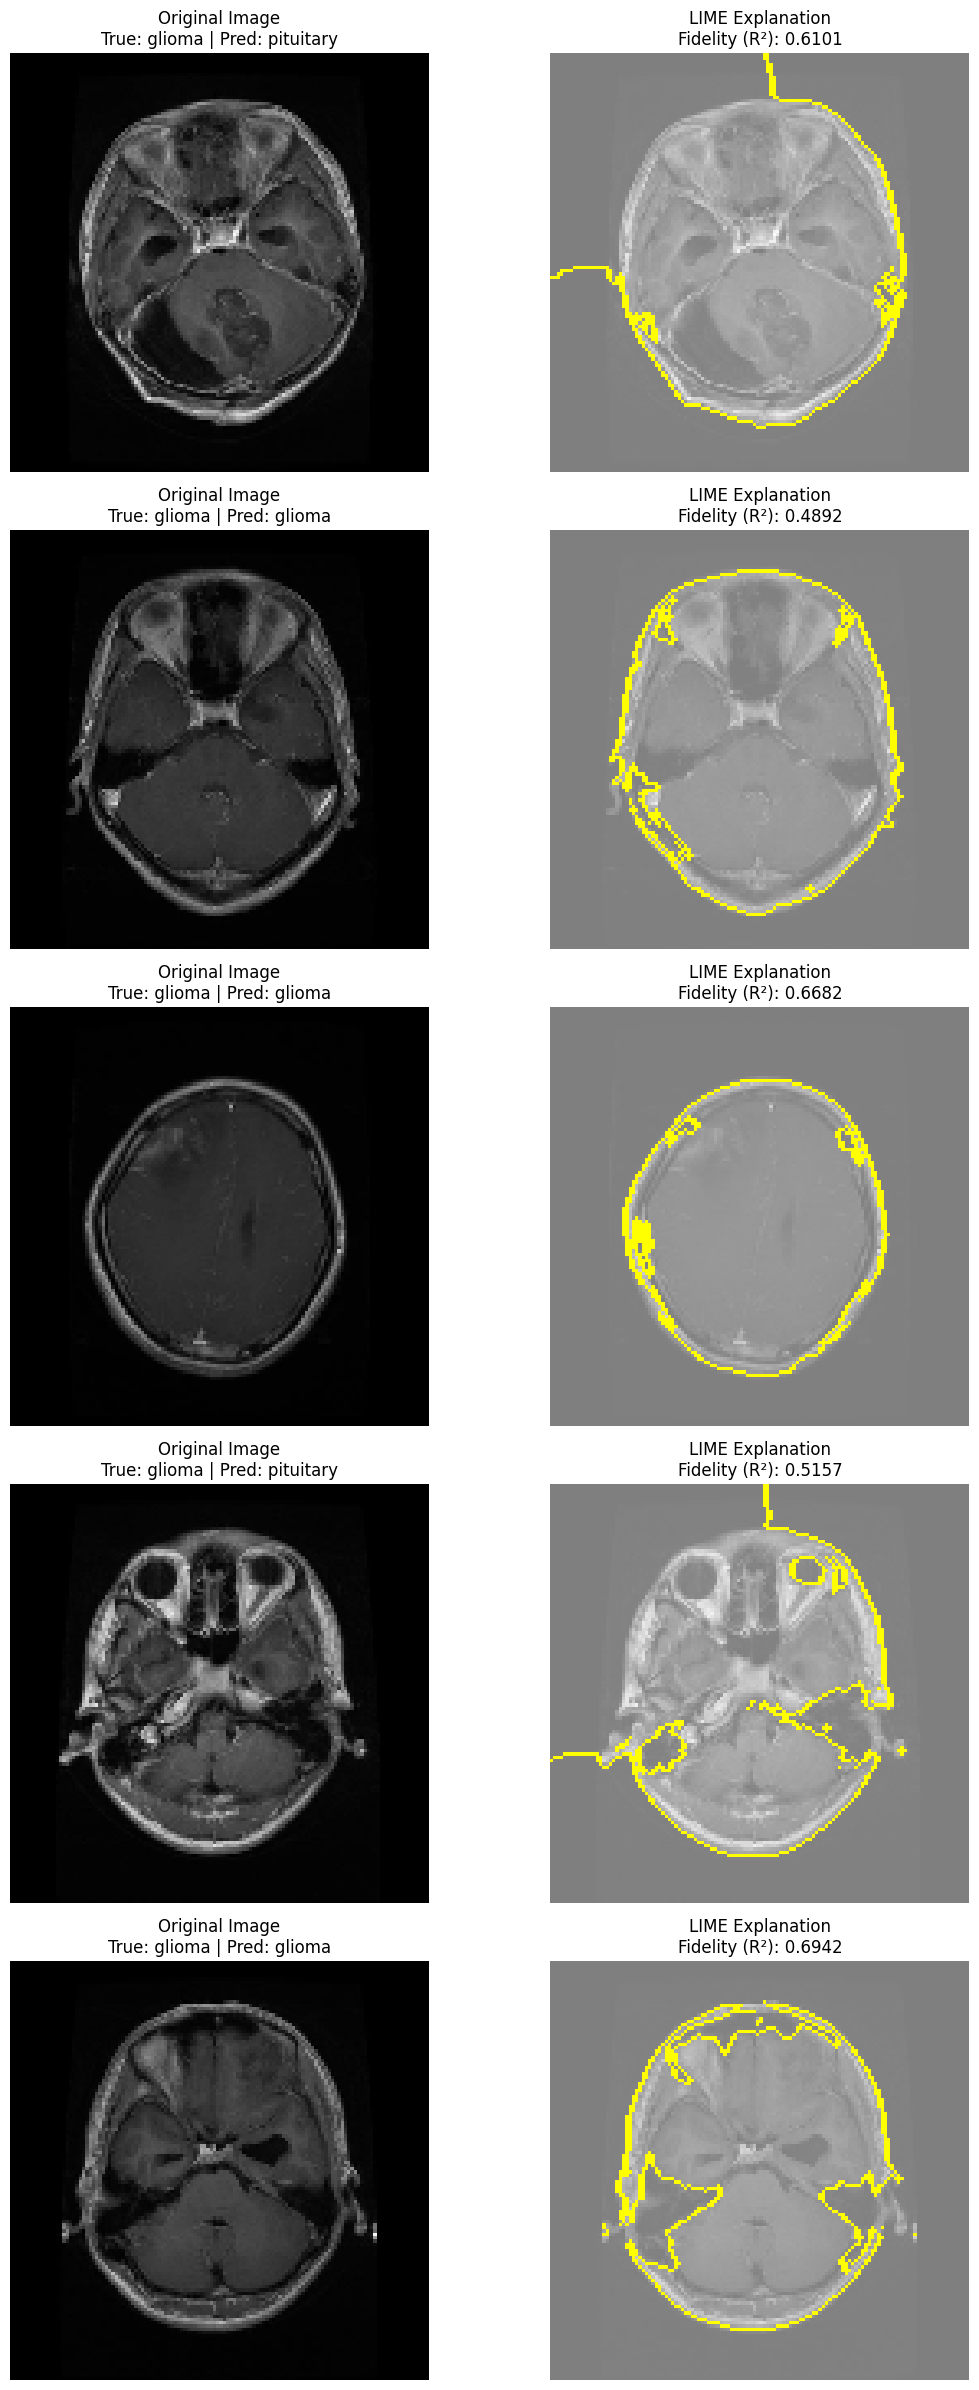

In [21]:
# VISUALIZE EXAMPLE LIME EXPLANATIONS
num_examples = 5  # Number of images to visualize
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 24))

print("\nGenerating example explanations with optimized LIME parameters...")

for i in range(num_examples):
    image = eval_images[i]
    true_label = class_names[np.argmax(eval_labels[i])]
    pred_probs = optimized_model.predict(image[np.newaxis, ...], verbose=0)[0]
    pred_label = class_names[np.argmax(pred_probs)]
    
    # Generate LIME explanation
    explanation = explain_image(
        optimized_model,
        image,
        num_samples=best_lime_params['num_samples'],
        num_features=best_lime_params['num_features'],
        kernel_size=best_lime_params['kernel_size'],
        max_dist=best_lime_params['max_dist'],
        ratio=best_lime_params['ratio']
    )
    
    # Use the top predicted label for visualization
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=best_lime_params['num_features'],
        hide_rest=False
    )
    
    # Original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image\nTrue: {true_label} | Pred: {pred_label}")
    axes[i, 0].axis('off')
    
    # LIME explanation overlay
    axes[i, 1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[i, 1].set_title(f"LIME Explanation\nFidelity (R²): {compute_fidelity(explanation):.4f}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Get all test images once 
all_images, all_labels = [], []
test.reset()
for _ in range(len(test)):
    imgs, lbls = next(test)
    all_images.append(imgs)
    all_labels.append(lbls)
all_images = np.vstack(all_images)
all_labels = np.vstack(all_labels)

# Random sample
num_eval_images = 10
idxs = np.random.choice(len(all_images), num_eval_images, replace=False)
eval_images = all_images[idxs].astype(np.float32)
eval_labels = all_labels[idxs]

# Check class distribution
print("Sample class labels:", np.argmax(eval_labels, axis=1))

# Compute accuracy
pred_probs = optimized_model.predict(eval_images, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(eval_labels, axis=1)

accuracy = np.mean(pred_labels == true_labels)
print(f"Accuracy on evaluation images: {accuracy:.4f}")
print("Predicted labels:", pred_labels)
print("True labels:     ", true_labels)

Sample class labels: [3 1 0 0 2 1 0 1 0 1]
Accuracy on evaluation images: 0.7000
Predicted labels: [3 3 1 0 2 1 0 1 0 2]
True labels:      [3 1 0 0 2 1 0 1 0 1]


In [22]:
# SAVE OPTIMIZED PARAMETERS
params_save_path = '/kaggle/working/lime_best_parameters.json'
with open(params_save_path, 'w') as f:
    json.dump(best_lime_params, f, indent=2)
print(f"\nSaved Best LIME Parameters to: {params_save_path}")

# SAVE OPTIMIZATION HISTORY
history_save_path = '/kaggle/working/lime_optimization_history.json'
lime_history_dict = {
    'iterations': tabu_lime_optimizer.history['iteration'],
    'current_scores': [float(s) for s in tabu_lime_optimizer.history['current_score']],
    'best_scores': [float(s) for s in tabu_lime_optimizer.history['best_score']],
    'move_types': tabu_lime_optimizer.history['move_type'],
    'tabu_sizes': tabu_lime_optimizer.history['tabu_size']
}
with open(history_save_path, 'w') as f:
    json.dump(lime_history_dict, f, indent=2)
print(f"Saved Tabu Search History to: {history_save_path}")


Saved Best LIME Parameters to: /kaggle/working/lime_best_parameters.json
Saved Tabu Search History to: /kaggle/working/lime_optimization_history.json


In [ ]:
# SAVE RESULTS
with open('/kaggle/working/shap_best_parameters.json', 'w') as f:
    json.dump(best_shap_params, f, indent=2)
with open('/kaggle/working/shap_optimization_history.json', 'w') as f:
    json.dump(tabu_shap_optimizer.history, f, indent=2)